<a href="https://colab.research.google.com/github/KwonHo-geun/AI_Study/blob/main/25.07.23_U2_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub

# Download latest version
#
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lgg-mri-segmentation


In [3]:
!cp -rf /kaggle/input/lgg-mri-segmentation/kaggle_3m .

In [4]:
import torch
from torch import nn
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import torchvision

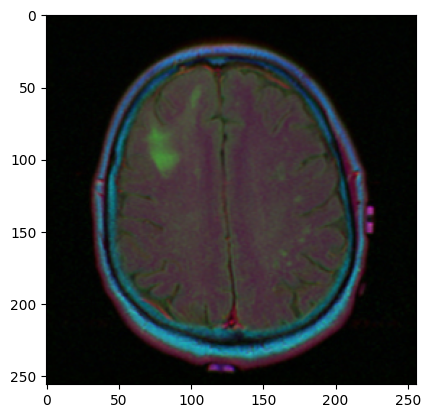

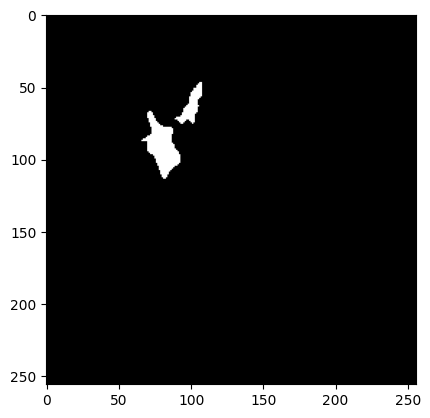

In [5]:
# src = cv2.imread(img_raw_path+'kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17.tif')
# mask = cv2.imread(img_raw_path+'kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17_mask.tif')
src = cv2.imread('kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17.tif')
mask = cv2.imread('kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17_mask.tif')
plt.imshow(src)
plt.show()
plt.imshow(mask)

In [6]:
data_train = []
data_valid = []
# .jpg file train : valid = 9 : 1
for root, dirs, filenames in os.walk('kaggle_3m'):
    if hash(root) % 10 == 0:
        data = data_valid
    else:
        data = data_train

    for filename in filenames:
        if 'mask' in filename:
            continue

        src_path = os.path.join(root, filename)
        first, last = os.path.splitext(filename)

        if last != '.tif':
            continue

        seg_path = os.path.join(root, first + '_mask.tif')

        data.append((src_path, seg_path))

len(data_train), len(data_valid)

(3641, 288)

In [7]:
from torch.utils.data import DataLoader
def collate_fn(data):
    x_list = []
    y_list = []

    for src_path, seg_path in data:
      #opencv(H,W,C) 기준 -> pythorch(C,H,W)로 변경하기 위해 사용
        src = torch.tensor(cv2.imread(src_path)).float() / 255
        src = src.permute(2, 0, 1) #HWC -> CHW

        seg = torch.tensor(cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)).float() / 255
        seg = seg.unsqueeze(0) #HW -> 1HW

        x_list.append(src)
        y_list.append(seg)

    xt = torch.stack(x_list)
    yt = torch.stack(y_list)

    return xt, yt #xt - N3HW   yt - N1HW

#데이터 셋, batch, shuffle, 함수젃용, 마지막 데이터셋 미니배치 사이즈가 4보다 작으면 버림, 데이터 속도 빠르기
loader_train = DataLoader(data_train, 4, True, collate_fn=collate_fn, drop_last=True, num_workers=2)
loader_valid = DataLoader(data_valid, 4, True, collate_fn=collate_fn, num_workers=2)

for src, seg in loader_train:
    break

src.shape, seg.shape

(torch.Size([4, 3, 256, 256]), torch.Size([4, 1, 256, 256]))

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#Residual + BatchNurm + Relu + Conv
class REBNCONV(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dirate=1):
        super(REBNCONV,self).__init__()
        # 3 * 3 Conv + BatchNorm + Relu
        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self,x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout

## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src,tar):

    src = F.upsample(src,size=tar.shape[2:],mode='bilinear')

    return src


### RSU-7 ###
class RSU7(nn.Module):#UNet07DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d =  self.rebnconv6d(torch.cat((hx7,hx6),1))
        hx6dup = _upsample_like(hx6d,hx5)

        hx5d =  self.rebnconv5d(torch.cat((hx6dup,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-6 ###
class RSU6(nn.Module):#UNet06DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)


        hx5d =  self.rebnconv5d(torch.cat((hx6,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-5 ###
class RSU5(nn.Module):#UNet05DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4 ###
class RSU4(nn.Module):#UNet04DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4F ###
class RSU4F(nn.Module):#UNet04FRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx2d = self.rebnconv2d(torch.cat((hx3d,hx2),1))
        hx1d = self.rebnconv1d(torch.cat((hx2d,hx1),1))

        return hx1d + hxin


##### U^2-Net ####
class U2NET2(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super().__init__()

        # self.stage1 = RSU7(in_ch,32,64)
        # self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(in_ch,32,128)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(128,64,256)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(256,128,256)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(256,128,256)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(256,128,256)

        # decoder
        self.stage5d = RSU4F(512,128,256)
        self.stage4d = RSU4(512,128,256)
        self.stage3d = RSU5(512,64,128)
        self.stage2d = RSU6(256,32,64)
        # self.stage1d = RSU7(128,16,64)

        # self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(128,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(256,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(256,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(256,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(5*out_ch,out_ch,1)

    def forward(self,x):

        hx = x

        #stage 1
        # hx1 = self.stage1(hx)
        # hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6 RSU 4F
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #-------------------- decoder --------------------
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))

        # hx2dup = _upsample_like(hx2d,hx1)
        # hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        # d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d2)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d2)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d2)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d2)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d2)

        d0 = self.outconv(torch.cat((d2,d3,d4,d5,d6),1))

        return F.sigmoid(d0), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)


In [9]:
import sys
sys.path.append('U-2-Net')

In [10]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [11]:
!git clone https://github.com/xuebinqin/U-2-Net.git

Cloning into 'U-2-Net'...
remote: Enumerating objects: 1077, done.
remote: Counting objects: 100% (422/422), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 1077 (delta 398), reused 380 (delta 380), pack-reused 655 (from 2)
Receiving objects: 100% (1077/1077), 66.95 MiB | 20.75 MiB/s, done.
Resolving deltas: 100% (539/539), done.


In [12]:
import sys
sys.path.append('U-2-Net')

In [13]:
from model import U2NET
#model = U2NET()
model = U2NET2()
model.to(device)
opt = torch.optim.Adam(model.parameters())

In [14]:
res = model(src.to(device))
for r in res:
    print(r.shape)

/tmp/ipython-input-8-918798563.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])


In [15]:
bce_loss = nn.BCELoss(size_average=True)

def muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels_v):

	loss0 = bce_loss(d0,labels_v)
	loss1 = bce_loss(d1,labels_v)
	loss2 = bce_loss(d2,labels_v)
	loss3 = bce_loss(d3,labels_v)
	loss4 = bce_loss(d4,labels_v)
	loss5 = bce_loss(d5,labels_v)
	loss6 = bce_loss(d6,labels_v)

	loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
	# print("l0: %3f, l1: %3f, l2: %3f, l3: %3f, l4: %3f, l5: %3f, l6: %3f\n"%(loss0.data.item(),loss1.data.item(),loss2.data.item(),loss3.data.item(),loss4.data.item(),loss5.data.item(),loss6.data.item()))

	return loss0, loss

#mod
def muti_bce_loss_fusion2(d0, d2, d3, d4, d5, d6, labels_v):

	loss0 = bce_loss(d0,labels_v) #0.1
	loss2 = bce_loss(d2,labels_v) #0.1
	loss3 = bce_loss(d3,labels_v) #0.1
	loss4 = bce_loss(d4,labels_v) #0.1
	loss5 = bce_loss(d5,labels_v) #0.2
	loss6 = bce_loss(d6,labels_v) #0.4

	loss = loss0 + loss2 + loss3 + loss4 + loss5 + loss6
	# print("l0: %3f, l1: %3f, l2: %3f, l3: %3f, l4: %3f, l5: %3f, l6: %3f\n"%(loss0.data.item(),loss1.data.item(),loss2.data.item(),loss3.data.item(),loss4.data.item(),loss5.data.item(),loss6.data.item()))

	return loss0, loss

/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [16]:
# muti_bce_loss_fusion(*res, seg.to(device))
muti_bce_loss_fusion2(*res, seg.to(device))

(tensor(0.5975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(3.9762, device='cuda:0', grad_fn=<AddBackward0>))

In [17]:
from model import U2NETP
modelp = U2NETP()

import torchsummary
torchsummary.summary(modelp.cuda(), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
          REBNCONV-4         [-1, 64, 256, 256]               0
            Conv2d-5         [-1, 16, 256, 256]           9,232
       BatchNorm2d-6         [-1, 16, 256, 256]              32
              ReLU-7         [-1, 16, 256, 256]               0
          REBNCONV-8         [-1, 16, 256, 256]               0
         MaxPool2d-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 16, 128, 128]           2,320
      BatchNorm2d-11         [-1, 16, 128, 128]              32
             ReLU-12         [-1, 16, 128, 128]               0
         REBNCONV-13         [-1, 16, 128, 128]               0
        MaxPool2d-14           [-1, 16,

/content/U-2-Net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


In [18]:
import torchsummary
torchsummary.summary(model.cuda(), (3, 256, 256))

/tmp/ipython-input-8-918798563.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 256, 256]           3,584
       BatchNorm2d-2        [-1, 128, 256, 256]             256
              ReLU-3        [-1, 128, 256, 256]               0
          REBNCONV-4        [-1, 128, 256, 256]               0
            Conv2d-5         [-1, 32, 256, 256]          36,896
       BatchNorm2d-6         [-1, 32, 256, 256]              64
              ReLU-7         [-1, 32, 256, 256]               0
          REBNCONV-8         [-1, 32, 256, 256]               0
         MaxPool2d-9         [-1, 32, 128, 128]               0
           Conv2d-10         [-1, 32, 128, 128]           9,248
      BatchNorm2d-11         [-1, 32, 128, 128]              64
             ReLU-12         [-1, 32, 128, 128]               0
         REBNCONV-13         [-1, 32, 128, 128]               0
        MaxPool2d-14           [-1, 32,

In [19]:
EPOCH = 10
for epoch in range(EPOCH):
    model.train()

    loss_list = []
    prec_list = []
    recall_list = []
    for src, seg in loader_train:
        seg = seg.to(device)
        #feed-forward
        results = model(src.to(device))
        #loss
        #mod
        loss0, loss = muti_bce_loss_fusion2(*results, seg * 0.8 + 0.1)
        #grad
        opt.zero_grad()
        loss.backward()
        #opt
        opt.step()

        prob = results[0]
        #데이터의 불균형 시 모델이 헷갈려서 그냥 비슷한걸로 분류하게 됨. 이걸 고치기 위해 데이터가 많거나 직접 수정해줘야함
        pred = (prob > 0.5).float()
        TP = ((pred == 1) & (seg == 1)).float().sum()
        FN = ((pred == 0) & (seg == 1)).float().sum()
        FP = ((pred == 1) & (seg == 0)).float().sum()
        recall = (TP / (TP + FN + 0.001)).item()
        prec = (TP / (TP + FP + 0.001)).item()

        loss_list.append(loss0.item())
        prec_list.append(prec)
        recall_list.append(recall)

        print(f'\r epoch={epoch}   loss={np.mean(loss_list):.4f}   recall={np.mean(recall_list):.4f}   prec={np.mean(prec_list):.4f} ', end='')
    print()


/tmp/ipython-input-8-918798563.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


 epoch=0   loss=0.3409   recall=0.1274   prec=0.3256 
 epoch=1   loss=0.3345   recall=0.3163   prec=0.5369 
 epoch=2   loss=0.3334   recall=0.3746   prec=0.5578 
 epoch=3   loss=0.3317   recall=0.4516   prec=0.5896 
 epoch=4   loss=0.3309   recall=0.4968   prec=0.6162 
 epoch=5   loss=0.3301   recall=0.5627   prec=0.6537 
 epoch=6   loss=0.3296   recall=0.5613   prec=0.6372 
 epoch=7   loss=0.3291   recall=0.6149   prec=0.6758 
 epoch=8   loss=0.3286   recall=0.6438   prec=0.6935 
 epoch=9   loss=0.3282   recall=0.6483   prec=0.6785 


In [20]:
model.eval()
with torch.no_grad():
    loss_list = []
    for src, seg in loader_valid:
        results = model(src.to(device))
        prob = results[0]
        seg = seg.to(device)
        loss = bce_loss(prob, seg * 0.8 + 0.1)
        loss_list.append(loss.item())
        #...
np.mean(loss_list)

/tmp/ipython-input-8-918798563.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


np.float64(0.3320181812677119)

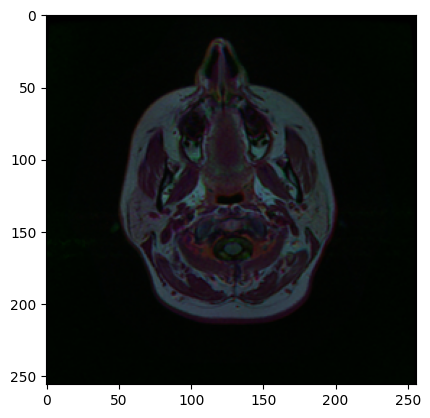

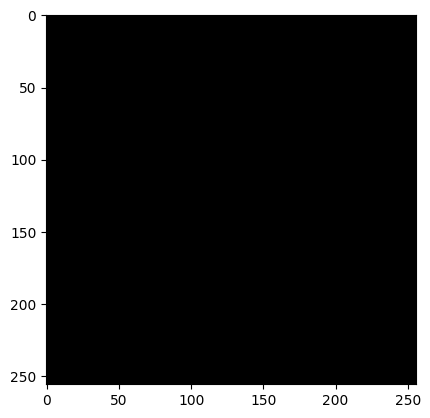

In [21]:
# 테스트... 이미지 불러오기
src_path = data_valid[3][0]
mask_path = data_valid[3][1]
src = cv2.imread(src_path)
mask = cv2.imread(mask_path)
plt.imshow(src)
plt.show()
plt.imshow(mask)

/tmp/ipython-input-8-918798563.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


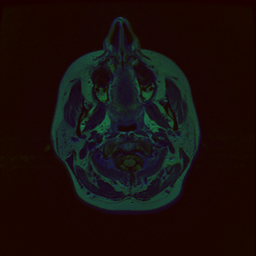

In [22]:
image = cv2.imread(src_path)
src = torch.tensor(image / 255).float().permute(2, 0, 1).unsqueeze(0)
model.eval()
with torch.no_grad():
    results = model(src.to(device))
pred = (results[0].cpu() > 0.3).float().reshape(256, 256).numpy()

prob = results[0].cpu().reshape(256, 256).numpy()
dst = image.copy()
# dst[pred == 1, :] = np.uint8(dst[pred == 1, :] * 0.5 + np.array([0, 0, 128]))
dst[..., 2] = np.uint8(prob * 255)

cv2_imshow(dst)

contours, h = cv2.findContours(np.uint8(pred * 255), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

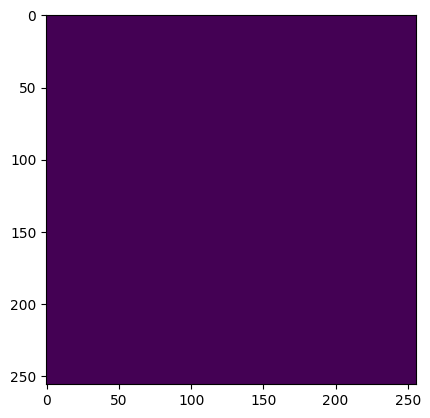

In [23]:
plt.imshow(pred)

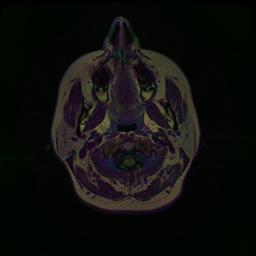

In [24]:
for con in contours:
    box = cv2.boundingRect(con)
    x, y, w, h = box
    x2 = x + w
    y2 = y + h
    cv2.rectangle(image, (x, y), (x2, y2), (0, 255, 0), 2)

cv2_imshow(image)